In [5]:

# from pathlib import Path
# import zarr

# def find_all_zarr_files():
#     """각 실험 디렉토리의 모든 zarr 파일 찾기"""
#     base_path = Path('./kaggle/input/czii-cryo-et-object-identification/train')
#     experiments = {}
    
#     for exp_dir in base_path.glob("**/VoxelSpacing10.000"):
#         exp_name = exp_dir.parent.name  # 실험 이름 (예: TS_5_4)
#         zarr_files = list(exp_dir.glob("*.zarr"))
        
#         if zarr_files:
#             experiments[exp_name] = {
#                 'path': str(exp_dir),
#                 'files': [f.name for f in zarr_files]
#             }
    
#     return experiments

# def test_all_zarr_files():
#     """모든 실험의 zarr 파일 정보 출력"""
#     experiments = find_all_zarr_files()
    
#     for exp_name, info in experiments.items():
#         print(f"\n실험: {exp_name}")
#         print(f"경로: {info['path']}")
#         print("zarr 파일들:")
#         for zarr_file in info['files']:
#             zarr_path = Path(info['path']) / zarr_file
#             try:
#                 root = zarr.open(str(zarr_path), mode='r')
#                 sample = root[0]
#                 print(f"- {zarr_file}: shape={sample.shape}")
#             except Exception as e:
#                 print(f"- {zarr_file}: 오류 발생 ({str(e)})")

# if __name__ == "__main__":
#     test_all_zarr_files()

In [6]:
import os
print("CPU 논리 코어 수:", os.cpu_count())


CPU 논리 코어 수: 12


In [2]:
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Dict, List, Tuple
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    NormalizeIntensityd
)

def calculate_patch_starts(dimension_size: int, patch_size: int) -> List[int]:
    """최소 오버랩으로 패치 시작 위치 계산"""
    if dimension_size <= patch_size:
        return [0]
    
    n_patches = np.ceil(dimension_size / patch_size)
    total_overlap = (n_patches * patch_size - dimension_size) / (n_patches - 1)
    
    positions = []
    for i in range(int(n_patches)):
        pos = int(i * (patch_size - total_overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in positions:
            positions.append(pos)
    
    return positions

class CryoET_2_5D_Dataset(Dataset):
    def __init__(self, 
                 data_dir: str, 
                 mode: str = 'train',
                 slice_depth: int = 3, 
                 crop_size: Tuple[int, int] = (96, 96),
                 transform = None):
        
        self.data_dir = Path(data_dir) / mode
        self.slice_depth = slice_depth
        self.crop_size = crop_size
        self.transform = transform
        self.pad_size = slice_depth // 2
        
        self.image_files = sorted(list((self.data_dir / 'images').glob('*.npy')))
        self.label_files = sorted(list((self.data_dir / 'labels').glob('*.npy')))
        
        # 모든 가능한 패치 위치 계산
        self.patch_indices = []
        for file_idx, image_file in enumerate(self.image_files):
            image = np.load(image_file)
            D, H, W = image.shape
            
            # z, y, x 축에 대한 시작 위치 계산
            z_starts = range(0, D - slice_depth + 1)
            y_starts = calculate_patch_starts(H, crop_size[0])
            x_starts = calculate_patch_starts(W, crop_size[1])
            
            # 모든 가능한 조합 저장
            for z in z_starts:
                for y in y_starts:
                    for x in x_starts:
                        self.patch_indices.append({
                            'file_idx': file_idx,
                            'z_start': z,
                            'y_start': y,
                            'x_start': x
                        })
    
    def __len__(self):
        return len(self.patch_indices)
    
    def __getitem__(self, idx):
        info = self.patch_indices[idx]
        file_idx = info['file_idx']
        z_start = info['z_start']
        y_start = info['y_start']
        x_start = info['x_start']
        
        # 데이터 로드
        image = np.load(self.image_files[file_idx])
        label = np.load(self.label_files[file_idx])
        
        # 패치 추출
        image_patch = image[
            z_start:z_start + self.slice_depth,
            y_start:y_start + self.crop_size[0],
            x_start:x_start + self.crop_size[1]
        ]
        
        # 중앙 슬라이스의 라벨
        center_z = z_start + self.slice_depth // 2
        label_patch = label[
            center_z,
            y_start:y_start + self.crop_size[0],
            x_start:x_start + self.crop_size[1]
        ]
        
        data_dict = {
            'image': np.array(image_patch)[None, ...],  # (1, D, H, W)
            'label': np.array(label_patch)[None, ...],  # (1, H, W)
            'crop_info': {
                'file_idx': file_idx,
                'z_start': z_start,
                'z_center': center_z,
                'y_start': y_start,
                'x_start': x_start,
                'crop_size': self.crop_size,
                'file_name': self.image_files[file_idx].stem
            }
        }
        
        if self.transform:
            data_dict = self.transform(data_dict)
            
        return data_dict

# Transform 설정
train_transforms = Compose([
    EnsureChannelFirstd(
        keys=['image', 'label'],
        channel_dim=0,
        allow_missing_keys=True
    ),
    NormalizeIntensityd(
        keys=['image'],
        allow_missing_keys=True
    )
])

def create_dataloaders(data_dir: str, batch_size: int = 8, crop_size: int = 96, num_workers: int = 0):
    train_ds = CryoET_2_5D_Dataset(
        data_dir=data_dir,
        mode='train_only_denoised',
        slice_depth=3,
        crop_size=(crop_size, crop_size),
        transform=train_transforms
    )
    
    val_ds = CryoET_2_5D_Dataset(
        data_dir=data_dir,
        mode='val',
        slice_depth=3,
        crop_size=(crop_size, crop_size),
        transform=None
    )
    
    train_loader = DataLoader(
        train_ds, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    
    return train_loader, val_loader


# import time
# from tqdm import tqdm

# if __name__ == "__main__":
#     data_dir = "./datasets"
#     crop_size = 126
#     batch_size = 256

#     # 테스트할 num_workers 값 리스트
#     num_workers_list = [0, 2, 4, 8]
#     num_batches_to_test = 10  # 테스트할 배치 수 제한

#     for num_workers in tqdm(num_workers_list, desc="Testing num_workers"):
#         print(f"\nTesting DataLoader with num_workers={num_workers}...")
        
#         # DataLoader 생성
#         start_time = time.time()
#         train_loader, val_loader = create_dataloaders(
#             data_dir=data_dir, 
#             batch_size=batch_size, 
#             crop_size=crop_size, 
#             num_workers=num_workers
#         )
#         loader_creation_time = time.time() - start_time
#         print(f"DataLoader 생성 시간: {loader_creation_time:.2f}초")

        # # 배치 로드 시간 측정
        # start_time = time.time()
        # for idx, batch in enumerate(train_loader):
        #     if idx >= num_batches_to_test:
        #         break
        # loading_time = time.time() - start_time
        # print(f"num_workers={num_workers} | {num_batches_to_test}개 배치 로드 시간: {loading_time:.2f}초")
        
        # batch = next(iter(train_loader))
        # print("이미지 shape:", batch['image'].shape)
        # print("라벨 shape:", batch['label'].shape)
        # print("Crop 정보:", batch['crop_info'])


# # 테스트
# if __name__ == "__main__":
#     data_dir = "./datasets"
#     crop_size = 126
#     batch_size = 256
#     num_workers = 0
#     train_loader, val_loader = create_dataloaders(data_dir, batch_size=batch_size, crop_size=crop_size, num_workers=num_workers)
    
#     # 데이터 확인
#     batch = next(iter(train_loader))
#     print("이미지 shape:", batch['image'].shape)
#     print("라벨 shape:", batch['label'].shape)
#     print("Crop 정보:", batch['crop_info'])

c:\Users\pook0\.conda\envs\UM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from CSANet.CSANet.networks.vit_seg_modeling import VisionTransformer as ViT_seg
from CSANet.CSANet.networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch
from monai.losses import TverskyLoss

# Model Configuration
vit_name = 'R50-ViT-B_16'
config_vit = CONFIGS_ViT_seg[vit_name]
config_vit.n_classes = 7  # Your number of classes
config_vit.n_skip = 3
vit_patches_size = 16
img_size = vit_patches_size * 8  # Match your patch size
batch_size = 64
# Training setup
num_epochs = 10
lamda = 0.2
lr = 0.001

data_dir = "./datasets"
train_loader, val_loader = create_dataloaders(data_dir, batch_size=batch_size, crop_size=img_size, num_workers=0)

# Initialize model
config_vit.patches.grid = (int(img_size / vit_patches_size), int(img_size / vit_patches_size))
model = ViT_seg(config_vit, img_size=img_size, num_classes=config_vit.n_classes)
model.cuda()

# Load pretrained weights
# model.load_from(weights=np.load(config_vit.real_pretrained_path, allow_pickle=True))

# optimizer = optim.AdamW(model.parameters(), lr=lr)

# TverskyLoss 설정
criterion = TverskyLoss(
    alpha=lamda,  # FP에 대한 가중치
    beta=1-lamda,   # FN에 대한 가중치
    include_background=True,
    softmax=True
)

# 체크포인트 저장 디렉토리 설정
checkpoint_base_dir = Path("./model_checkpoints")
checkpoint_dir = checkpoint_base_dir / f"img{img_size}_lr{lr}_lambda{lamda}_batch{batch_size}"

# 체크포인트 디렉토리가 있고 best_model.pt가 존재하면 로드
if checkpoint_dir.exists():
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        print(f"기존 best model 발견: {best_model_path}")
        model.load_state_dict(torch.load(best_model_path))
        print("기존 학습된 가중치를 성공적으로 로드했습니다.")
    else:
        print("새로운 학습을 시작합니다.")
        model.load_from(weights=np.load(config_vit.real_pretrained_path, allow_pickle=True))
else:
    print("새로운 학습을 시작합니다.")
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    model.load_from(weights=np.load(config_vit.real_pretrained_path, allow_pickle=True))

optimizer = optim.AdamW(model.parameters(), lr=lr)

# Training loop 수정
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
        for batch_data in pbar:
            images = batch_data['image'].cuda()
            labels = batch_data['label'].cuda()
            
            # 차원 분리 및 reshape
            # print(images.shape)
            if images.shape[2] == 96:
                images = images.permute(0, 1, 4, 2, 3)
                labels = labels.permute(0, 1, 4, 2, 3)
                # print(images.shape)
            # prev_image, image, next_image = torch.split(images, 1, dim=2)
            center = images.shape[2] // 2
            prev_image = images[:, :, 0:center, :, :]
            image = images[:, :, center:center+1, :, :]
            next_image = images[:, :, center+1:, :, :]
            
            # 필요한 차원 형태로 변환
            prev_image = prev_image.squeeze(2)  # [B, C, H, W]
            image = image.squeeze(2)
            next_image = next_image.squeeze(2)
            
            # 라벨 처리
            #labels = labels[:, :, center:center+1, :, :]
            #labels = labels.squeeze(2)  # [B, 1, H, W]
            labels = labels.squeeze(1)  # [B, H, W]

            optimizer.zero_grad()
            outputs = model(prev_image, image, next_image)

            # 라벨을 long으로 변환하고 one-hot encoding
            labels = labels.long()
            labels_onehot = torch.nn.functional.one_hot(labels, num_classes=config_vit.n_classes)  # [B, H, W, C]
            # 차원 순서 변경: [B, H, W, C] -> [B, C, H, W]
            labels_onehot = labels_onehot.permute(0, 3, 1, 2).float()
            
            loss = criterion(outputs, labels_onehot)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
    
    # Training loop는 그대로 유지

    # Training loop 내부의 validation과 saving 코드 수정
    # Validation
    if (epoch + 1) % 1 == 0:  # Validate every 5 epochs
        model.eval()
        val_loss = 0
        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}', leave=False)
            for val_data in val_loop:
                val_images = val_data['image'].cuda()
                val_labels = val_data['label'].cuda()
                
                # Training과 동일한 방식으로 데이터 처리
                val_prev, val_curr, val_next = torch.split(val_images, 1, dim=2)
                val_prev = val_prev.squeeze(2)
                val_curr = val_curr.squeeze(2)
                val_next = val_next.squeeze(2)
                
                val_labels = val_labels.squeeze(1)
                val_labels = val_labels.long()
                
                val_outputs = model(val_prev, val_curr, val_next)
                
                val_labels_onehot = torch.nn.functional.one_hot(val_labels, num_classes=config_vit.n_classes)
                val_labels_onehot = val_labels_onehot.permute(0, 3, 1, 2).float()
                
                current_loss = criterion(val_outputs, val_labels_onehot).item()
                val_loss += current_loss
                val_loop.set_postfix({'val_loss': current_loss})
        
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
        # Best model 저장
        if epoch == 0 or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, checkpoint_dir / 'best_model.pt')
            print(f'Best model saved with validation loss: {best_val_loss/len(val_loader):.4f}')
            
    # 체크포인트 저장
    if (epoch + 1) % 1 == 0:  # Save every 25 epochs        
        with tqdm(total=1, desc=f'Saving checkpoint for epoch {epoch+1}', leave=False) as pbar:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
            }, checkpoint_dir / f'checkpoint_epoch_{epoch+7}.pt')
            pbar.update(1)


기존 best model 발견: model_checkpoints\img128_lr0.001_lambda0.2_batch64\best_model.pt


C:\Users\pook0\AppData\Local\Temp\ipykernel_11524\2610061122.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


기존 학습된 가중치를 성공적으로 로드했습니다.


Epoch 1/10:   0%|          | 0/356 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [4]:
from CSANet.CSANet.networks.vit_seg_modeling import VisionTransformer as ViT_seg
from CSANet.CSANet.networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from pathlib import Path
import numpy as np
import torch
from scipy import ndimage
from typing import List, Dict, Tuple
from tqdm import tqdm

def get_center_points(label_map: np.ndarray, crop_info: Dict, exclude_class: int = 2) -> List[Dict]:
    """객체 중심점 추출 (class 1 제외)"""
    centers = []
    
    for class_id in np.unique(label_map):
        # class 1 제외
        if class_id == 0 or class_id == exclude_class:
            continue
            
        # 현재 클래스에 대한 바이너리 마스크
        class_mask = label_map == class_id
        labeled_array, num_features = ndimage.label(class_mask)
        
        # 각 객체의 중심점 계산
        for label_id in range(1, num_features + 1):
            object_mask = labeled_array == label_id
            coords = np.array(np.nonzero(object_mask))  # [num_dims, N]
            
            if coords.size > 0:
                # 3D 데이터의 경우 3개의 좌표가 있을 수 있으므로 차원 확인
                if coords.shape[0] == 2:  # 2D case
                    y, x = coords.mean(axis=1)
                else:  # 3D case or other
                    coord_means = coords.mean(axis=1)
                    y, x = coord_means[-2:]  # 마지막 두 차원을 y, x로 사용
                
                # crop 좌표를 원본 좌표로 변환
                orig_x = x + crop_info['x_start']
                orig_y = y + crop_info['y_start']
                orig_z = crop_info['z_center']
                
                centers.append({
                    'x': float(orig_x),
                    'y': float(orig_y),
                    'z': float(orig_z),
                    'class': int(class_id)
                })
    
    return centers

def calculate_distance(point1: Dict, point2: Dict) -> float:
    """두 점 사이의 유클리드 거리"""
    return np.sqrt(
        (point1['x'] - point2['x'])**2 + 
        (point1['y'] - point2['y'])**2 + 
        (point1['z'] - point2['z'])**2
    )

def calculate_fbeta_score(pred_centers: List[Dict], 
                         gt_centers: List[Dict], 
                         distance_threshold: float = 10.0,
                         beta: float = 4.0) -> float:
    """F-beta score 계산 (beta=4)"""
    if len(pred_centers) == 0 and len(gt_centers) == 0:
        return 1.0
    if len(pred_centers) == 0 or len(gt_centers) == 0:
        return 0.0
    
    # 거리 행렬 계산
    distances = np.zeros((len(pred_centers), len(gt_centers)))
    for i, pred in enumerate(pred_centers):
        for j, gt in enumerate(gt_centers):
            # 같은 클래스인 경우에만 매칭
            if pred['class'] == gt['class']:
                distances[i, j] = calculate_distance(pred, gt)
            else:
                distances[i, j] = float('inf')
    
    # 매칭 및 점수 계산
    true_positives = 0
    matched_gt = set()
    
    for i in range(len(pred_centers)):
        if np.min(distances[i]) > distance_threshold:
            continue
            
        min_dist_idx = np.argmin(distances[i])
        if min_dist_idx not in matched_gt:
            true_positives += 1
            matched_gt.add(min_dist_idx)
    
    precision = true_positives / len(pred_centers) if len(pred_centers) > 0 else 0
    recall = true_positives / len(gt_centers) if len(gt_centers) > 0 else 0
    
    # F-beta 계산
    beta_square = beta ** 2
    if precision == 0 and recall == 0:
        return 0.0
    fbeta = (1 + beta_square) * (precision * recall) / (beta_square * precision + recall)
    
    return fbeta

def test_segmentation(model, test_loader, device, config_vit):
    """테스트 및 평가"""
    model.eval()
    results = []
    total_score = 0
    num_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # 데이터 준비
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            crop_info = batch['crop_info']
            
            # # crop_info 디버깅
            # print("Crop info keys:", crop_info.keys())
            # for k, v in crop_info.items():
            #     print(f"{k}: type={type(v)}, shape/len={v.shape if torch.is_tensor(v) else len(v) if hasattr(v, '__len__') else 'scalar'}")
            
            # 2.5D 입력 준비
            prev_image = images[:, :, 0:1, :, :].squeeze(2)
            curr_image = images[:, :, 1:2, :, :].squeeze(2)
            next_image = images[:, :, 2:3, :, :].squeeze(2)
            
            # 추론
            outputs = model(prev_image, curr_image, next_image)
            pred = torch.argmax(outputs, dim=1)  # (B, H, W)
            
            # 배치의 각 샘플에 대해 처리
            for i in range(pred.size(0)):
                try:
                    # crop_info 처리
                    batch_crop_info = {}
                    for k, v in crop_info.items():
                        if torch.is_tensor(v):
                            batch_crop_info[k] = v[i].item()
                        elif isinstance(v, (list, tuple)) and len(v) > i:
                            batch_crop_info[k] = v[i]
                        else:
                            batch_crop_info[k] = v
                    
                    # 예측 및 정답 라벨에서 중심점 추출
                    pred_centers = get_center_points(
                        pred[i].cpu().numpy(), 
                        batch_crop_info
                    )
                    gt_centers = get_center_points(
                        labels[i].cpu().numpy(),
                        batch_crop_info
                    )
                    
                    # F-beta score 계산
                    score = calculate_fbeta_score(pred_centers, gt_centers, beta=4.0)
                    
                    results.append({
                        'file_name': batch_crop_info.get('file_name', f'sample_{num_samples}'),
                        'pred_centers': pred_centers,
                        'gt_centers': gt_centers,
                        'score': score
                    })
                    
                    total_score += score
                    num_samples += 1
                    
                except Exception as e:
                    print(f"Error processing sample {i}: {str(e)}")
                    continue
    
    avg_score = total_score / num_samples if num_samples > 0 else 0
    print(f"\n평균 F4-score: {avg_score:.4f}")
    
    return results

def load_best_model(model, checkpoint_dir: str = "./model_checkpoints"):
    """베스트 모델 가중치 로드"""
    checkpoint_path = Path(checkpoint_dir) / 'best_model.pt'  # .pth에서 .pt로 변경
    
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"베스트 모델을 찾을 수 없습니다: {checkpoint_path}")
    
    print(f"베스트 모델 로드 중: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path))
    model = model.cuda()
    model.eval()
    
    return model

# 사용 예시
model = ViT_seg(config_vit, img_size=img_size, num_classes=config_vit.n_classes)
model = load_best_model(model, checkpoint_dir=checkpoint_dir)

# 테스트 실행
if __name__ == "__main__":
    # self_test용 데이터셋 생성
    test_ds = CryoET_2_5D_Dataset(
        data_dir="./datasets",
        mode='self_test',  # 경로 변경
        slice_depth=3,
        crop_size=(img_size, img_size),
        transform=None  # 테스트시에는 transform 없음
    )
    
    # DataLoader 설정
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,  # 테스트시에는 shuffle 없음
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 결과 디렉토리 생성
    save_dir = checkpoint_dir / "results"
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # 테스트 실행 및 결과 저장
    results = test_segmentation(model, test_loader, device, config_vit)
    np.save(save_dir / "test_results.npy", results)

베스트 모델 로드 중: model_checkpoints\img128_lr0.001_lambda0.2_batch64\best_model.pt


C:\Users\pook0\AppData\Local\Temp\ipykernel_11524\1770661916.py:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))
Testing


평균 F4-score: 0.5921


C:\Users\pook0\AppData\Local\Temp\ipykernel_11524\4075414228.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


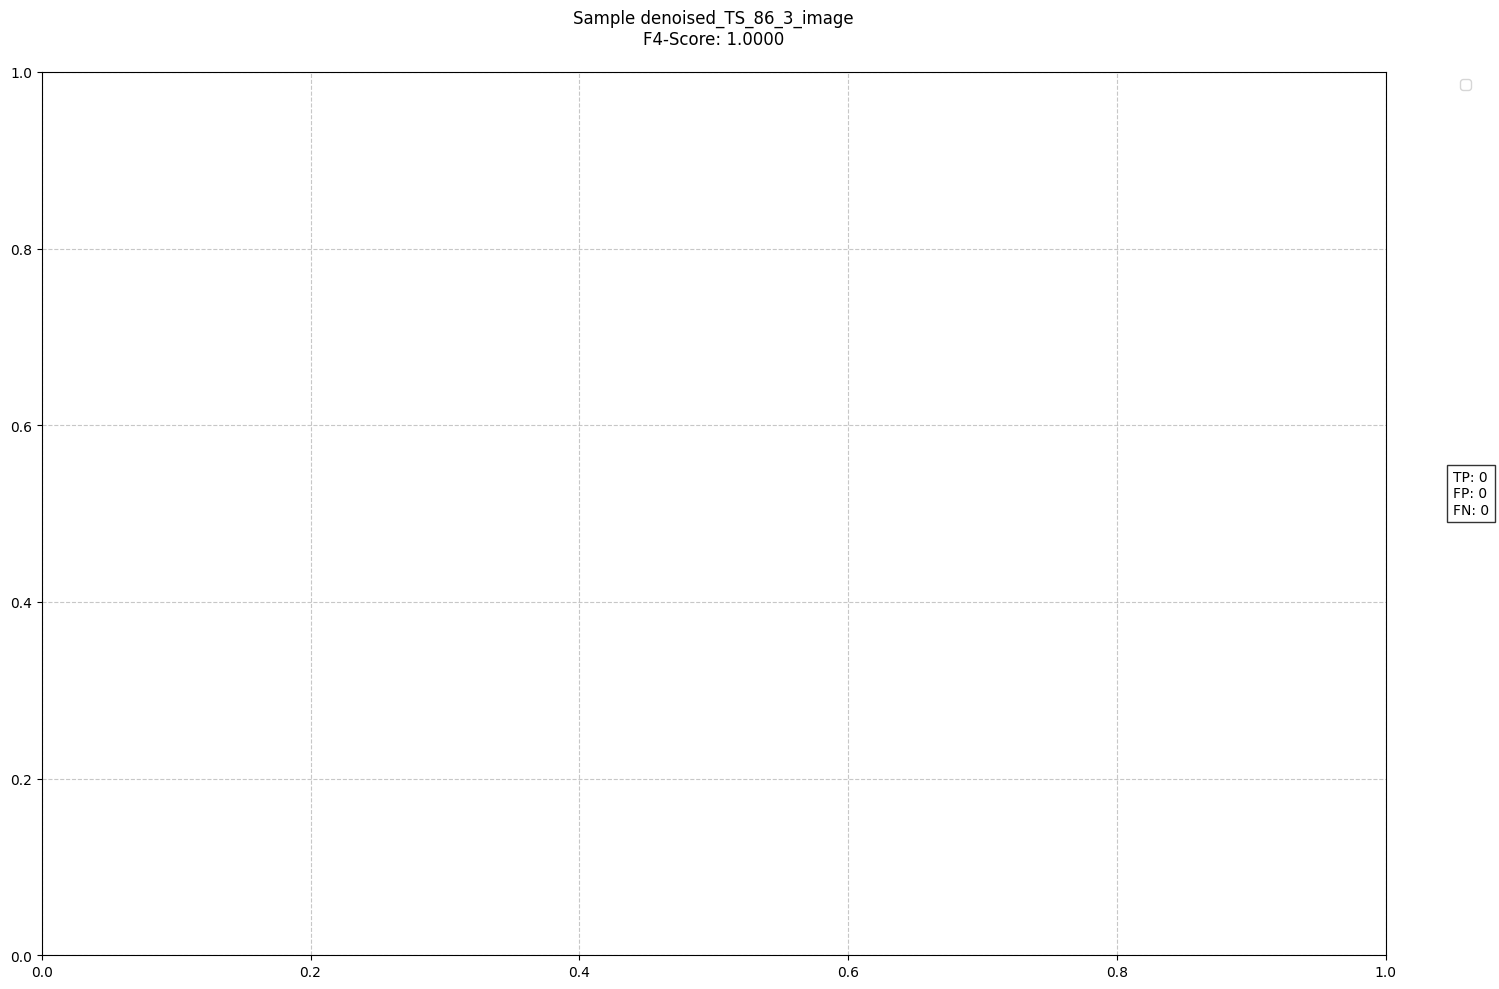

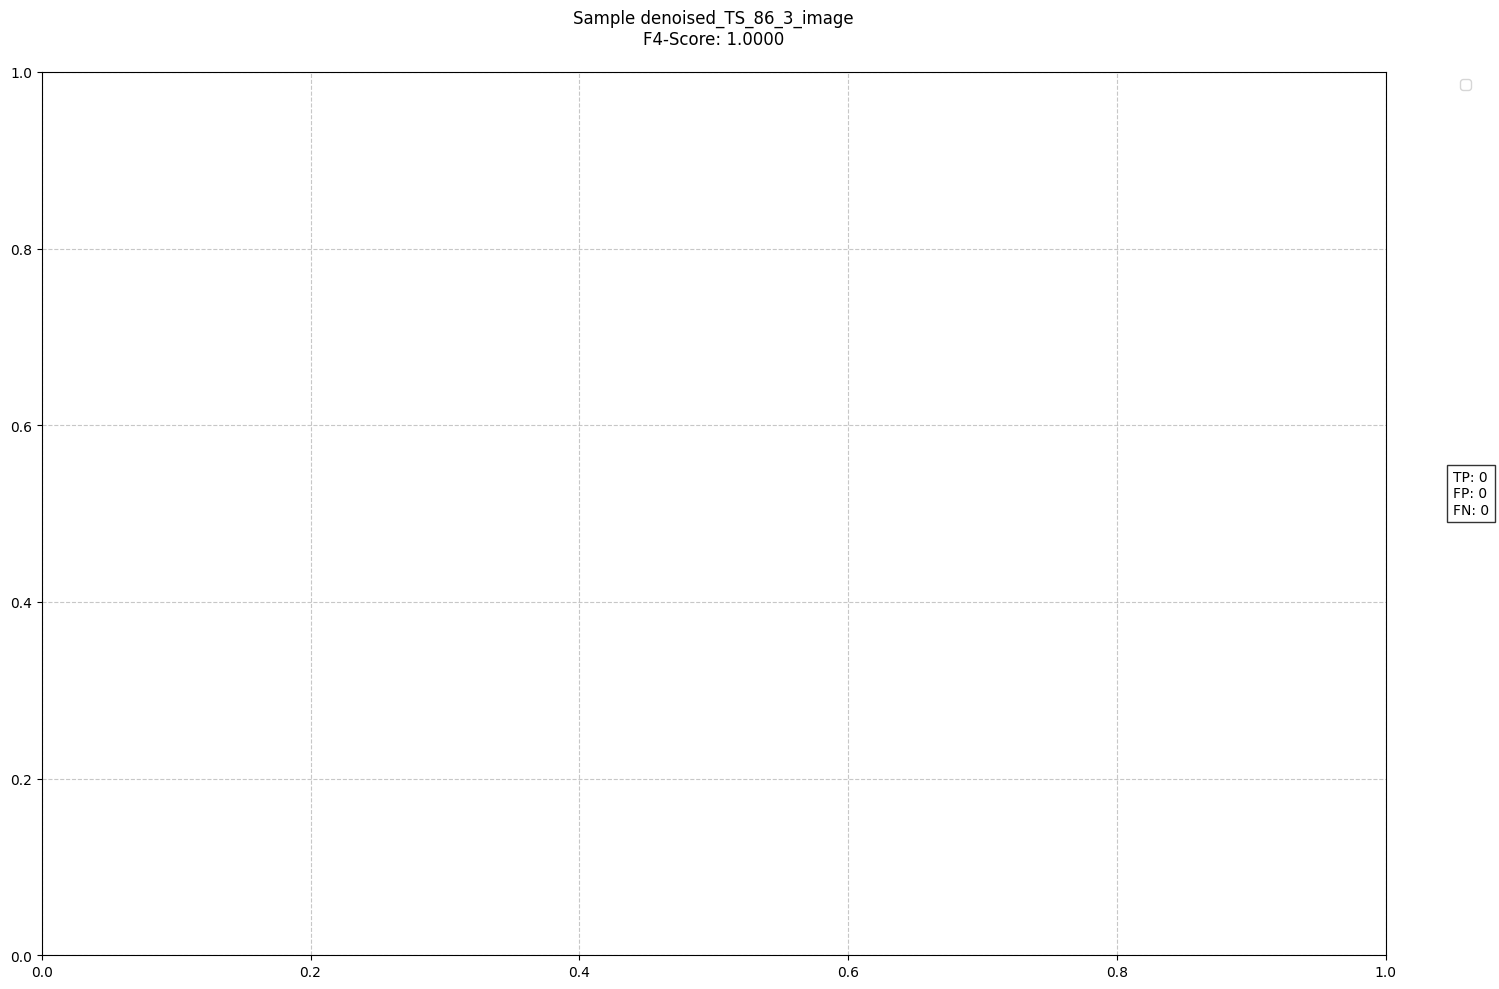

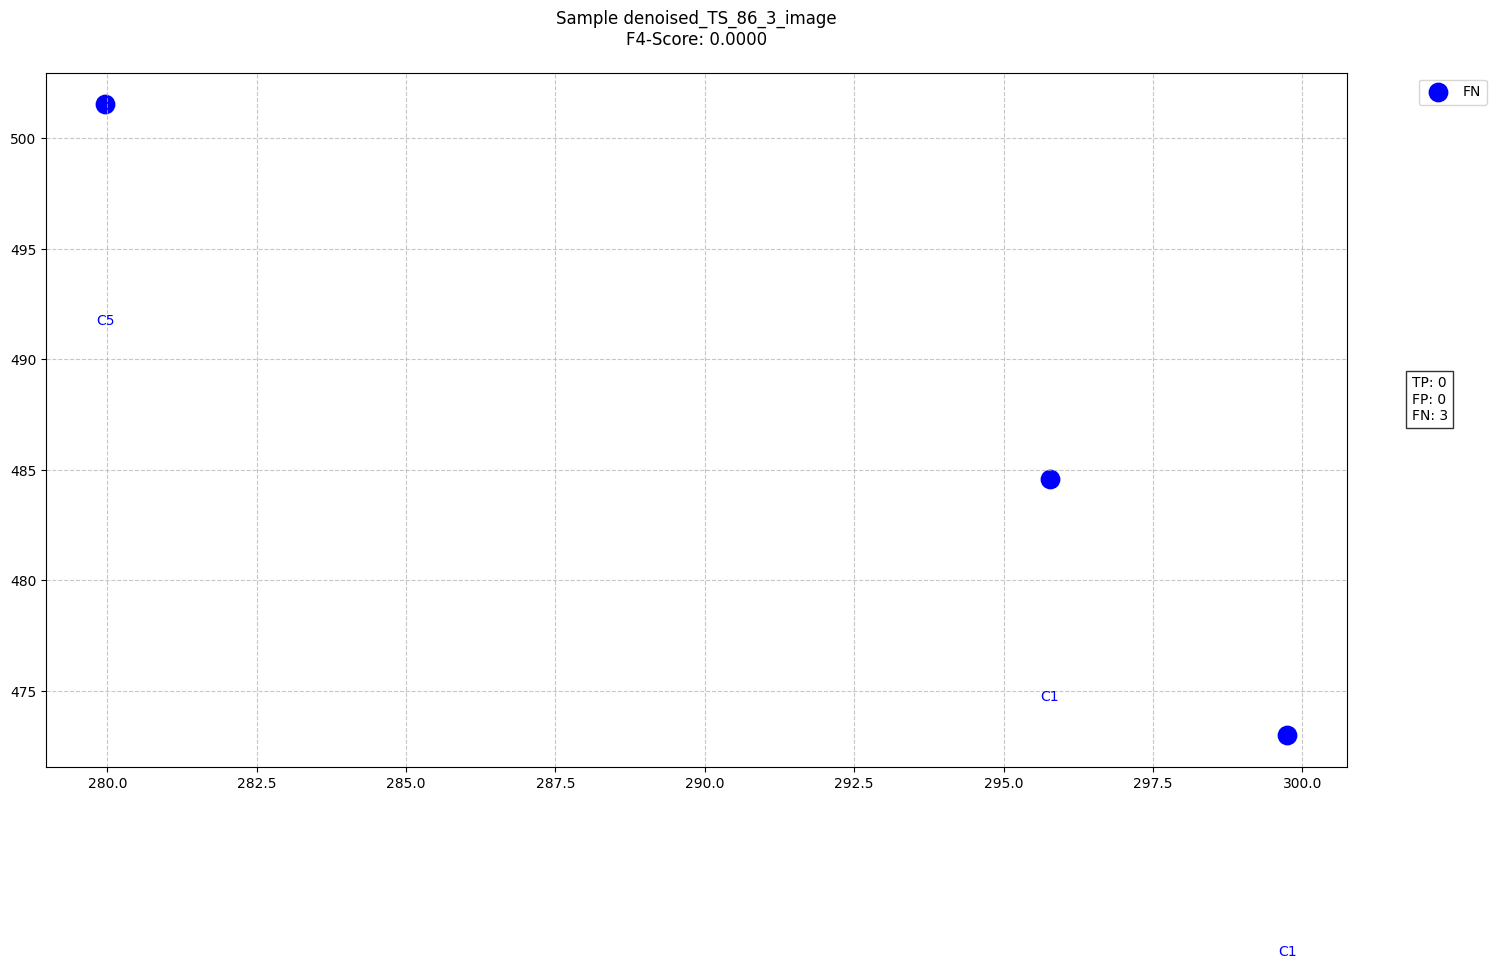

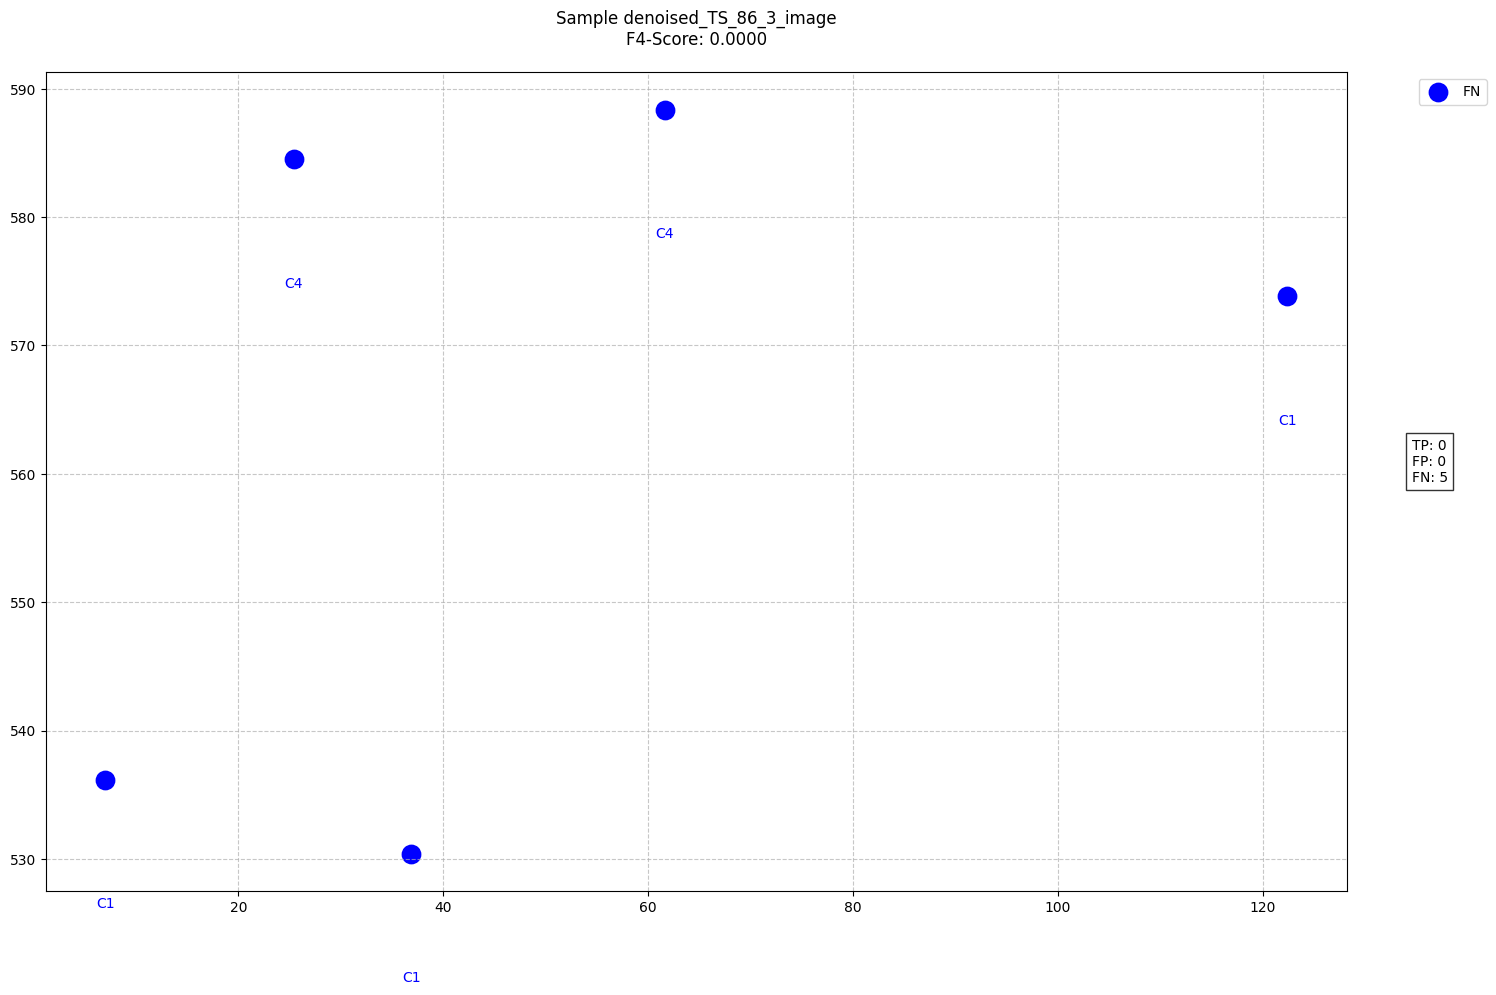

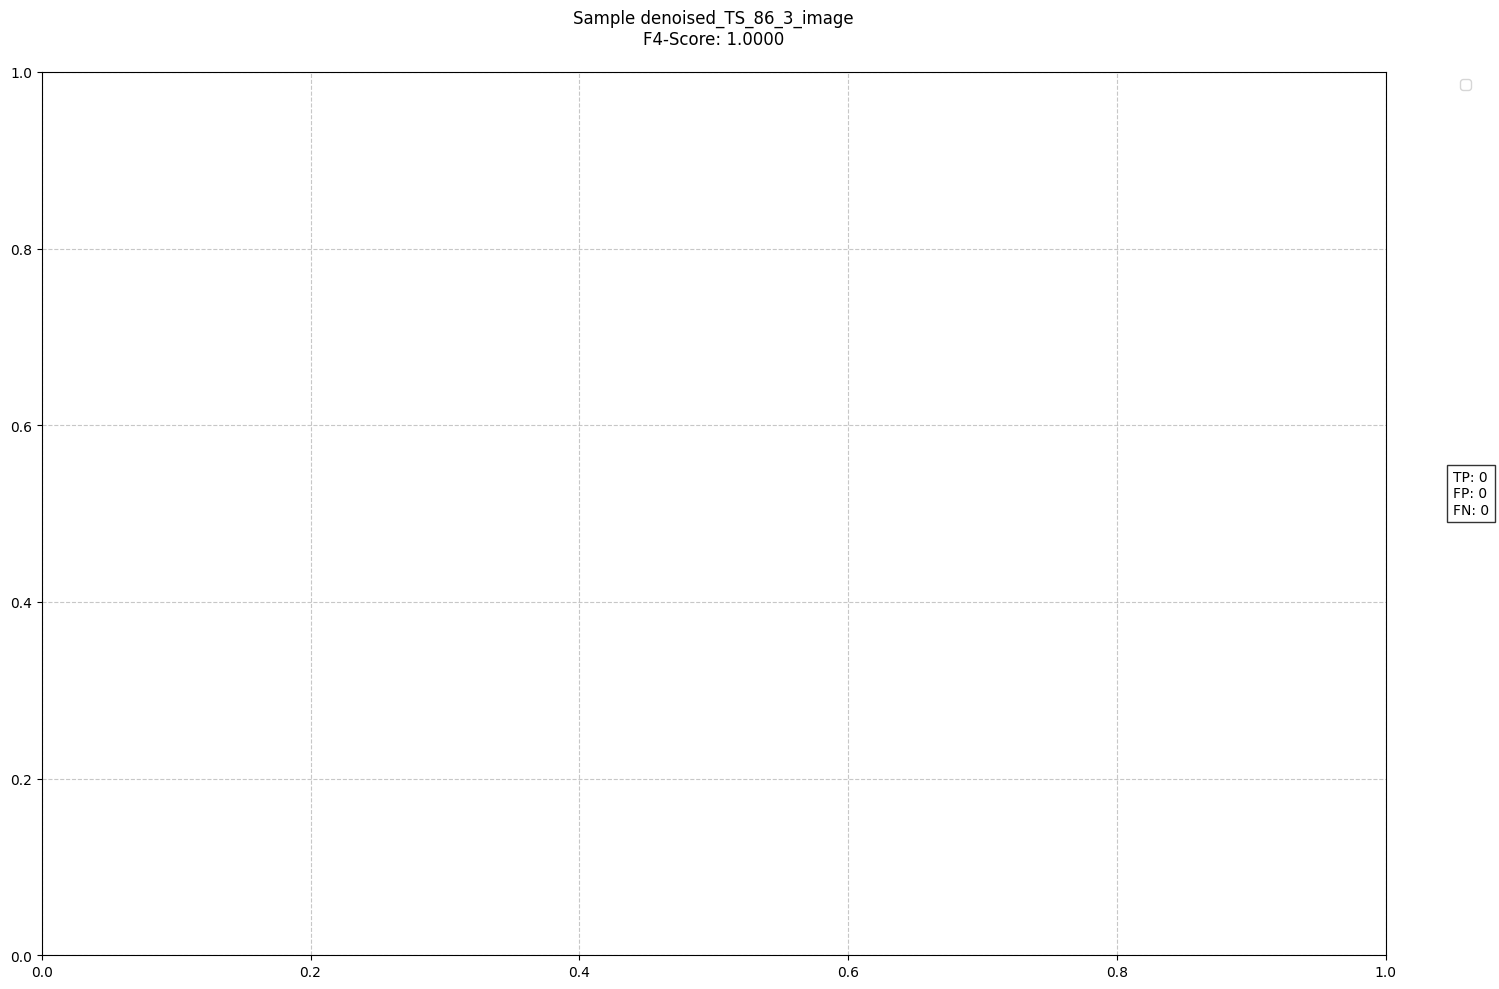


=== 결과 통계 ===
평균 F4-score: 0.5921
최대 F4-score: 1.0000
최소 F4-score: 0.0000


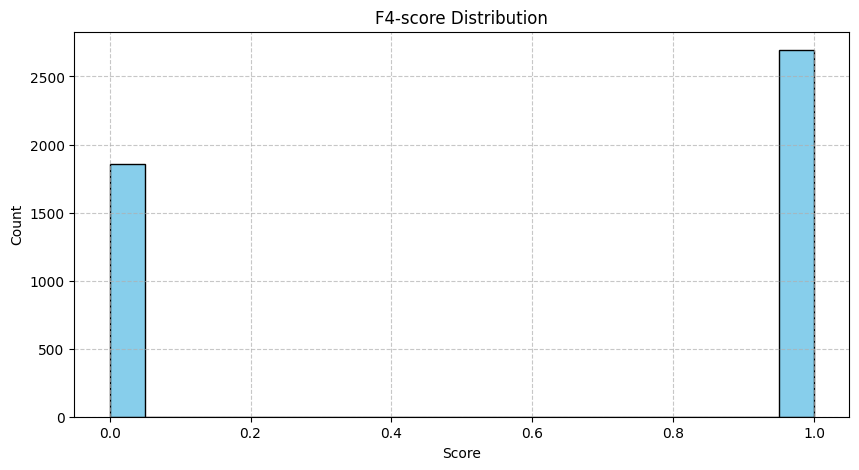

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch

def categorize_predictions(pred_centers, gt_centers, distance_threshold=10.0):
    """예측을 TP, FP, FN으로 분류"""
    tp_pred = []
    fp_pred = []
    fn_gt = gt_centers.copy()
    
    # TP와 FP 찾기
    for pred in pred_centers:
        matched = False
        for gt in gt_centers:
            if pred['class'] == gt['class']:
                dist = np.sqrt(
                    (pred['x'] - gt['x'])**2 + 
                    (pred['y'] - gt['y'])**2 + 
                    (pred['z'] - gt['z'])**2
                )
                if dist <= distance_threshold:
                    tp_pred.append(pred)
                    fn_gt.remove(gt)  # matched GT 제거
                    matched = True
                    break
        if not matched:
            fp_pred.append(pred)
            
    return tp_pred, fp_pred, fn_gt

def visualize_results(results_path: str = "./results/test_results.npy", num_samples: int = 5):
    """테스트 결과 시각화"""
    results = np.load(results_path, allow_pickle=True)
    indices = np.random.choice(len(results), min(num_samples, len(results)), replace=False)
    
    for idx in indices:
        result = results[idx]
        
        # TP, FP, FN 분류
        tp_pred, fp_pred, fn_gt = categorize_predictions(
            result['pred_centers'], 
            result['gt_centers']
        )
        
        # 그림 설정
        plt.figure(figsize=(15, 10))
        
        # 결과 시각화
        plt.title(f"Sample {result['file_name']}\nF4-Score: {result['score']:.4f}", pad=20)
        
        # True Positives (녹색 X)
        for center in tp_pred:
            plt.scatter(center['x'], center['y'], c='g', marker='x', s=150, 
                       label='TP' if center == tp_pred[0] else "", linewidth=2)
            plt.text(center['x'], center['y']+5, f"C{center['class']}", 
                    color='g', fontsize=10, ha='center')
        
        # False Positives (빨간색 X)
        for center in fp_pred:
            plt.scatter(center['x'], center['y'], c='r', marker='x', s=150, 
                       label='FP' if center == fp_pred[0] else "", linewidth=2)
            plt.text(center['x'], center['y']+5, f"C{center['class']}", 
                    color='r', fontsize=10, ha='center')
        
        # False Negatives (파란색 원)
        for center in fn_gt:
            plt.scatter(center['x'], center['y'], c='b', marker='o', s=150, 
                       label='FN' if center == fn_gt[0] else "", facecolors='none', linewidth=2)
            plt.text(center['x'], center['y']-10, f"C{center['class']}", 
                    color='b', fontsize=10, ha='center')
        
        # 범례 및 그리드
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 통계 텍스트 추가
        stats_text = f"TP: {len(tp_pred)}\nFP: {len(fp_pred)}\nFN: {len(fn_gt)}"
        plt.text(1.05, 0.5, stats_text, transform=plt.gca().transAxes, 
                bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
    
    # 전체 통계
    scores = [r['score'] for r in results]
    print(f"\n=== 결과 통계 ===")
    print(f"평균 F4-score: {np.mean(scores):.4f}")
    print(f"최대 F4-score: {np.max(scores):.4f}")
    print(f"최소 F4-score: {np.min(scores):.4f}")
    
    # Score 분포 히스토그램
    plt.figure(figsize=(10, 5))
    plt.hist(scores, bins=20, color='skyblue', edgecolor='black')
    plt.title("F4-score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

if __name__ == "__main__":
    visualize_results(results_path=save_dir / "test_results.npy", num_samples=5)